# Feature Engineer

## Import Data

__DataFrames:__  
df_model - df with all the features (independent festures + Target)  
x - df with all independent features
y - df with dependent feature  
x_train - df with training data from x  
x_train_out - df with training data from x with outliers treatment applied  
x_test - df with test data from x  
x_test_out - df with test data from x with outliers treatment applied  



In [26]:
def analyzeQuantiles (data,):
    
    """"""""""""""""
    
    Receives:
            pandas dataframe
            
    Creates a df that analyzes outliers by creating 2 disparity features that measure the level of the outliers.
    The fist measure divides de 95% quantile by the 90% and the second divides the mean by the median
    
    Note: thresholds can be fyrther adjusted
    
    """""""""""""""""
    df_out = data
    
    quantile_disp = np.round(df_out.describe([.25, .5, .75,0.9,0.95]).T).iloc[:,:-1]
    quantile_disp['disparity'] = (quantile_disp['95%'] / quantile_disp['90%']).replace(np.inf,0)
    quantile_disp['mean_disp'] = (quantile_disp['mean'] / quantile_disp['50%']).replace(np.inf,0)

    quantile_disp = quantile_disp.sort_values(ascending=False,by = 'mean_disp')
    display(quantile_disp.iloc[:10])
    
    return(quantile_disp)

def replaceOutliers (data,upper_thresh, lower_thresh):
    """"""""""""""""
    
    Receives:
            pandas dataframe
            
    Replaces outliers with the nearest quantile, per example an observation of quantile 99 will be replaced by the quantile 90
    
    Note: thresholds can be fyrther adjusted
    
    """""""""""""""""
    df_out = data.copy()
    
    cols = df_out.select_dtypes(include = np.number).columns
    rem_cols = df_out.select_dtypes(exclude = np.number).columns
    for col in cols:
        
        upper_quant = df_out[col].quantile(upper_thresh)
        lower_quant = df_out[col].quantile(lower_thresh)
        
        df_out.loc[df_out[col]>upper_quant, col] = upper_quant
        df_out.loc[df_out[col]<lower_quant, col] = lower_quant
        
        
    df_out = pd.concat([df_out[cols],
                        df_out[rem_cols]],
                      axis=1)
        
    return(df_out)

def splitData (df, date):
    
    # df_sector = pd.read_csv(f'{input_path}\companyInfo_sector.csv').drop(columns = 'Unnamed: 0')
    print('Nr of rows:')
    print(df_model.shape[0])

    #drop columns related to the target - avoid leakage
    x = df_model.drop(columns = leakage_cols).copy()

    #set y
    y = df_model['Target_0.15'].copy()
    date_ = '2018-01-01'

    #split the data into training and testing 
    x_train = x.loc[x.index.get_level_values(1)<date_].copy()
    y_train = y.loc[y.index.get_level_values(1)<date_,:].copy()
    x_test = x.loc[x.index.get_level_values(1)>=date_].copy()
    y_test = y.loc[y.index.get_level_values(1)>=date_,:].copy()

    #for each target column
    #create a dict containing each target 
    y_train_dict = dict()
    y_test_dict = dict()
    for col in target_cols:
        y_train_dict[col] = df_model.loc[df_model.index.isin(x_train.index),col].copy()
        y_test_dict[col] = df_model.loc[df_model.index.isin(x_test.index),col].copy()

    #perform outliers treatment
    #get x_train out
    df_out = x_train.copy()
    df_out_ = replaceOutliers(df_out,
                              0.99,
                              0.01)
    x_train_out = df_out_.copy()

    #get x_test out
    df_out_test = x_test.copy()
    df_out_test_ = replaceOutliers(df_out_test,
                                   0.99,
                                   0.01)
    x_test_out = df_out_test_.copy()
    return(x_train,x_train_out,x_test, x_test_out,y_train_dict ,y_test_dict, y_train,y_test)


import sys
sys.path.insert(1, r'C:\Users\rafae\Personal\Github\Functions\Data-Science-Functions')
sys.path.insert(2, r'C:\Users\rafae\Personal\Github\Functions\Data-Science-Functions\Functions')

import Visualizations_Functions as viz 
import Classification_CV as class_cv
import DataPreparation as preprocess 
import FeatureExtraction as ft_extract 
import DataScalling as scalling
import FeatureSelection as ft_selection

import pandas as pd
import numpy as np 

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.tree import DecisionTreeClassifier

import warnings
warnings.filterwarnings('ignore')

#set preferences
sns.set_style('whitegrid')

#set color for graphs
#set color for graphs
palette = ["#e41a1c", "#377eb8", "#4daf4a", "#984ea3"]

#import data containing sector information
input_path = r'E:\Database\Reasearch Topic\Long-Term'

leakage_cols = ['datePredict', 'futPrice_S&P', 's&p', 'close', 'futPrice',
       'futReturns', 'futReturns_S&P', 'excessReturns', 'Target_0',
       'Target_0.05', 'Target_0.15']

growth_cols = ['YoY_costOfRevenue', 'YoY_grossProfit', 'YoY_costAndExpenses',
       'YoY_ebitda', 'YoY_operatingIncome', 'YoY_netIncome', 'YoY_eps']

#import model from path
df_full_path_skew = r'E:\Database\Reasearch Topic\Long-Term\Data Preparation\Long-Term-V1\LongTerm-V1-DataPreparation_Skew.csv'

df_model = pd.read_csv(df_full_path_skew,).set_index(['symbol','date','fillingDate','year','quarter'])

#set major columns
target_cols = df_model.columns[df_model.columns.str.contains('Target')]
date = '2018-01-01'
x_train,x_train_out,x_test, x_test_out,y_train_dict ,y_test_dict, y_train,y_test = splitData(df_model, date) 
df_explor = pd.concat([x_train_out, y_train],axis=1)

df_full_path= r'E:\Database\Reasearch Topic\Long-Term\Data Preparation\Long-Term-V1\LongTerm-V1-DataPreparation.csv'
df = pd.read_csv(df_full_path_skew,).set_index(['symbol','date','fillingDate','year','quarter'])
df_explor_orig = df.copy()
df_explor_orig = replaceOutliers(df,0.95,0.05).copy()

Nr of rows:
56604


In [4]:
import pandas as pd
import numpy as np 
class importData ():

    def __init__(self,):
        dataPath = r'D:\Thesis Reseearch\Asset Allocation - Clean\Asset-Allocation\Long-Term-CAPM\SampleData\Sample\\'
        
        skewPath = f'{dataPath}\LongTerm-DataPreparation_Skew.csv'
        self.df_skew = pd.read_csv(skewPath)

        # self.ticker = ticker

In [5]:
import_obj = importData()

In [6]:
import_obj.df_skew

,symbol,date,fillingDate,year,quarter,revenue,costOfRevenue,grossProfit,grossProfitRatio,researchAndDevelopmentExpenses,...,industry_Utilities—Renewable,industry_Waste Management,sector_priceEarningsRatio_bin,netDebt_bin,netIncome_bin,netProfitMargin_bin,mainSector,revenuePerShare,Target_0,Target_0.15
0,AAON,2004-03-31,2004-05-07,2004.0,2.0,334.698623,310.006937,197.476630,0.205393,0.000000,...,0.0,0.0,False,False,True,False,False,0.840302,False,False
1,AAPL,2004-03-27,2004-05-06,2004.0,2.0,1240.514875,1113.067295,809.267233,0.277632,497.318983,...,0.0,0.0,False,True,False,False,True,0.453563,True,True
2,ABC,2004-03-31,2004-05-12,2004.0,2.0,2373.053504,2338.063816,835.126733,0.043585,0.000000,...,0.0,0.0,False,False,False,True,False,3.102745,False,False
3,ABCB,2004-03-31,2004-05-07,2004.0,2.0,242.695312,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,False,False,True,False,False,1.058232,False,False
4,ACGL,2004-03-31,2004-05-10,2004.0,2.0,907.078341,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,True,False,False,False,False,1.448638,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72533,VALU,2022-10-31,2022-12-12,2022.0,4.0,215.916406,155.623572,184.662154,0.625571,0.000000,...,0.0,0.0,False,False,True,False,False,1.020632,False,False
72534,VIAV,2022-10-01,2022-11-04,2022.0,4.0,676.935460,500.532765,569.596513,0.595745,374.681211,...,0.0,0.0,False,False,True,False,True,1.110842,False,False
72535,WGO,2022-11-26,2022-12-16,2022.0,4.0,983.805831,925.135115,543.335550,0.168452,0.000000,...,0.0,0.0,False,False,True,False,True,3.152232,False,False
72536,WMT,2022-10-31,2022-12-01,2022.0,4.0,5346.301342,4871.569359,3338.215069,0.243435,0.000000,...,0.0,0.0,True,False,False,True,False,3.834219,False,False


### Feature Distribution

Number of metric features : 41
Plotting Histograms
Nr of metrics features: 10


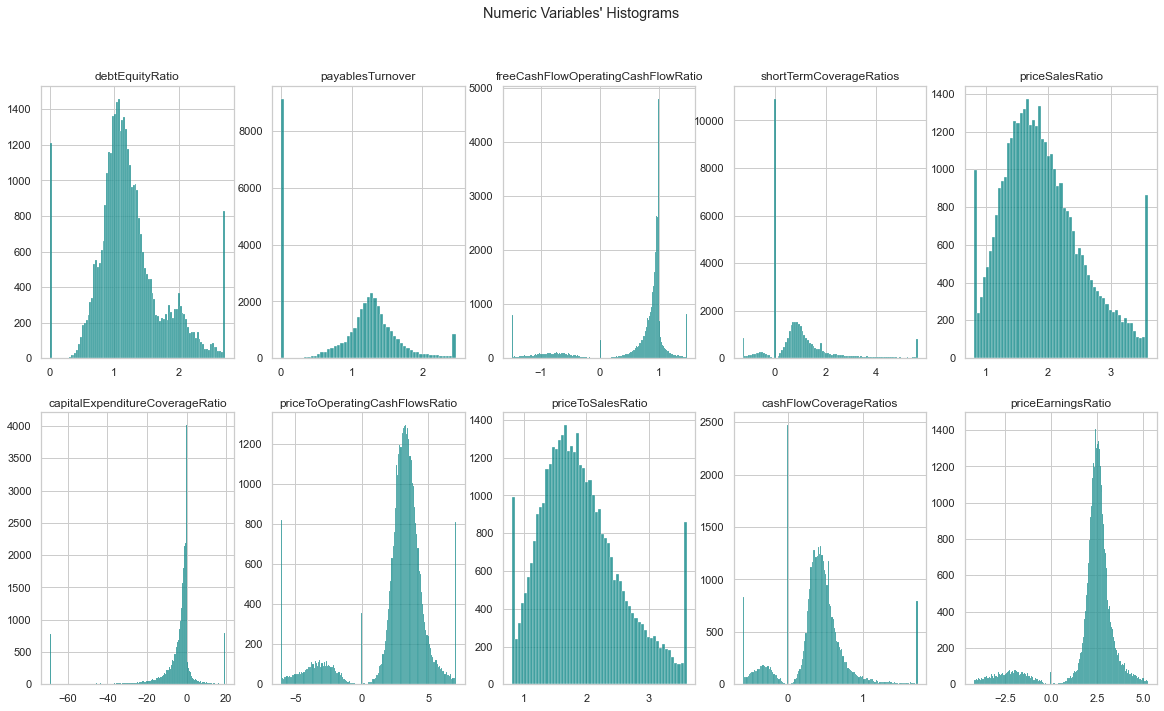

Plotting Histograms
Nr of metrics features: 10


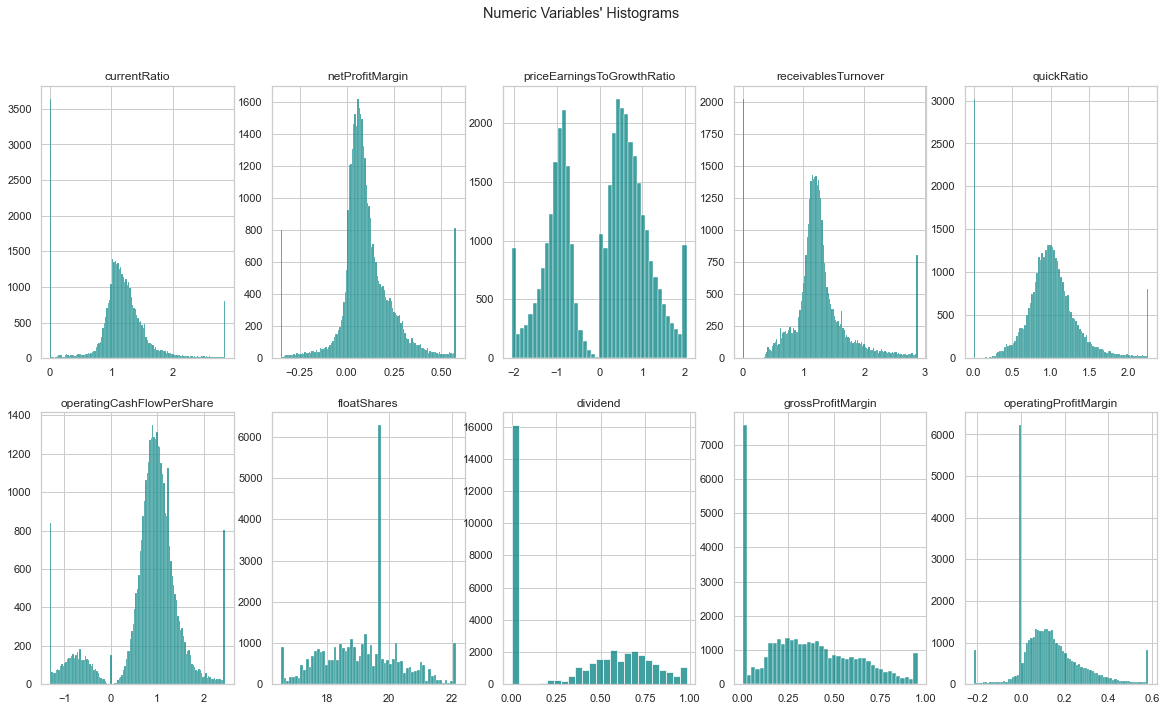

Plotting Histograms
Nr of metrics features: 10


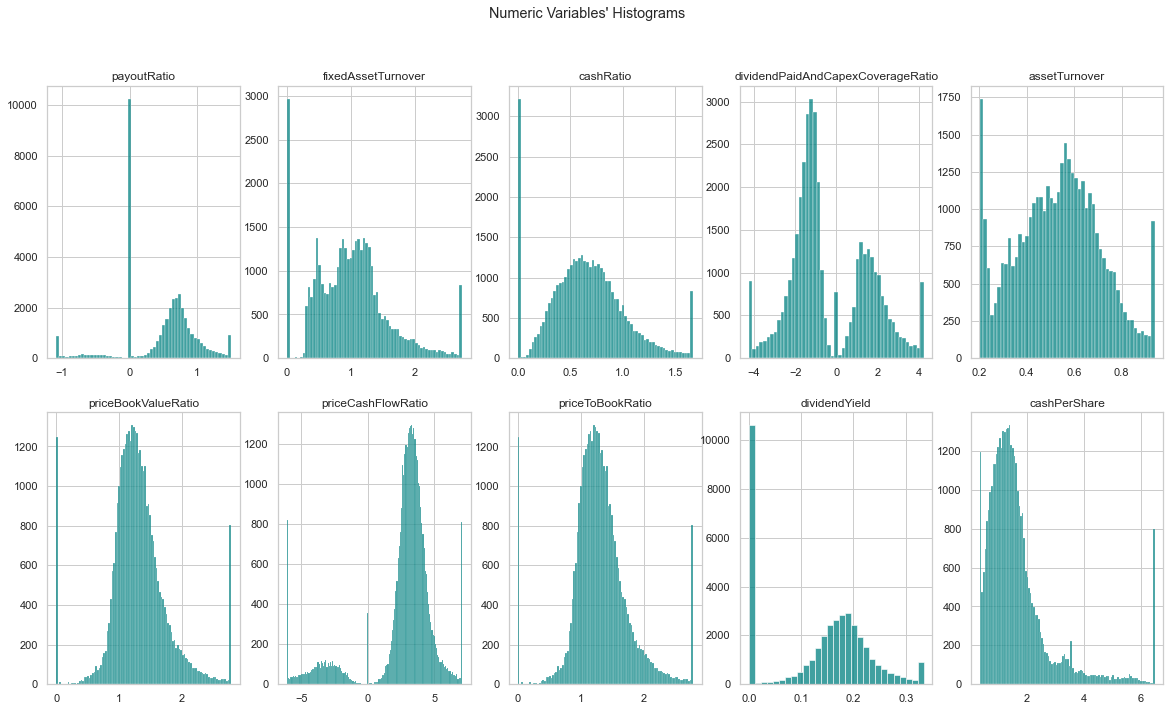

Plotting Histograms
Nr of metrics features: 10


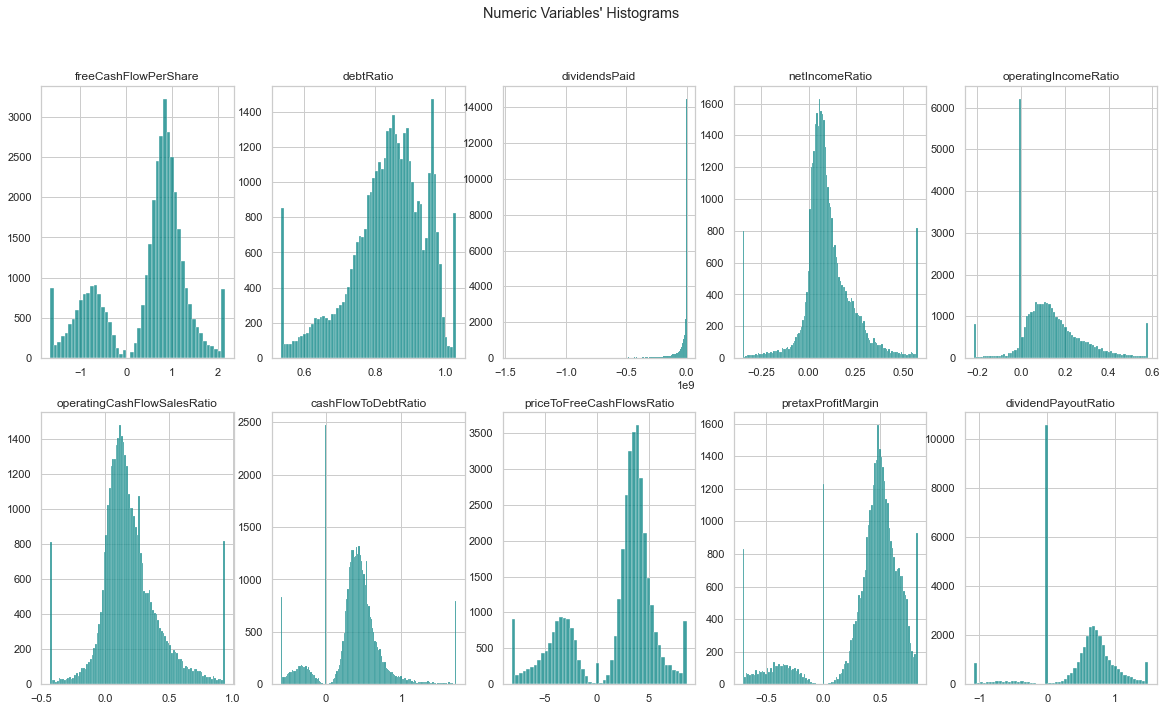

Plotting Histograms
Nr of metrics features: 1


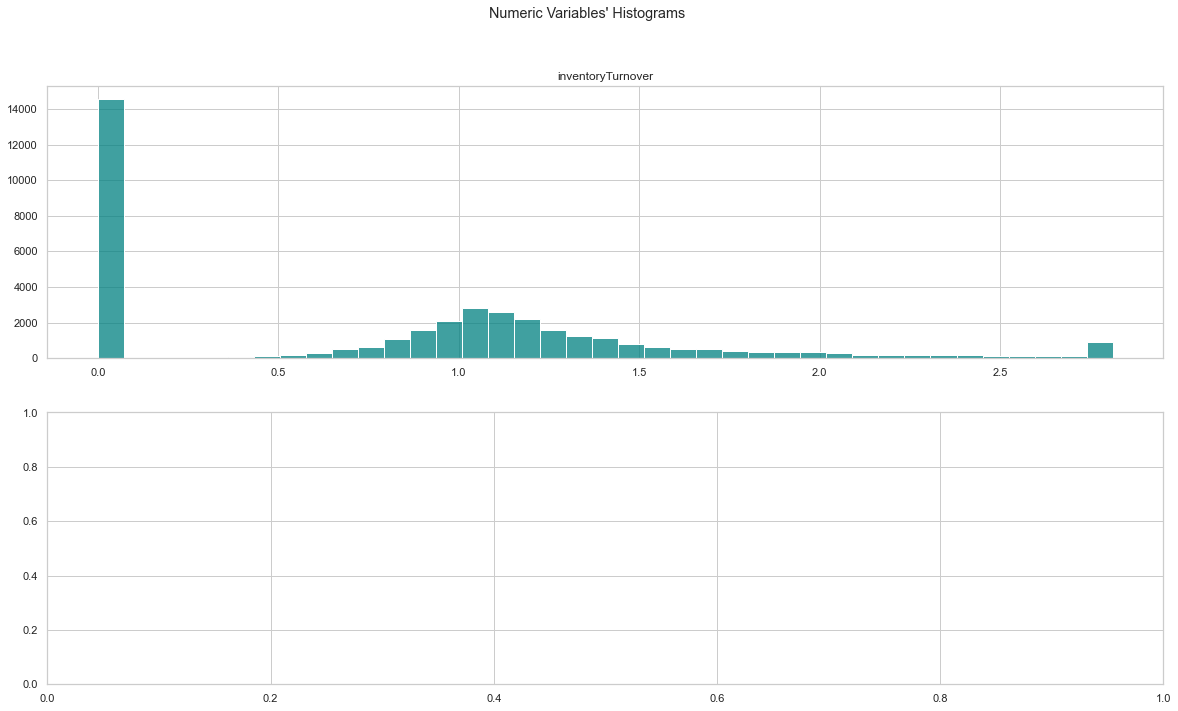

In [12]:
viz.Histogram(x_train_out)

Number of metric features : 48
Plotting Histograms
Nr of metrics features: 10


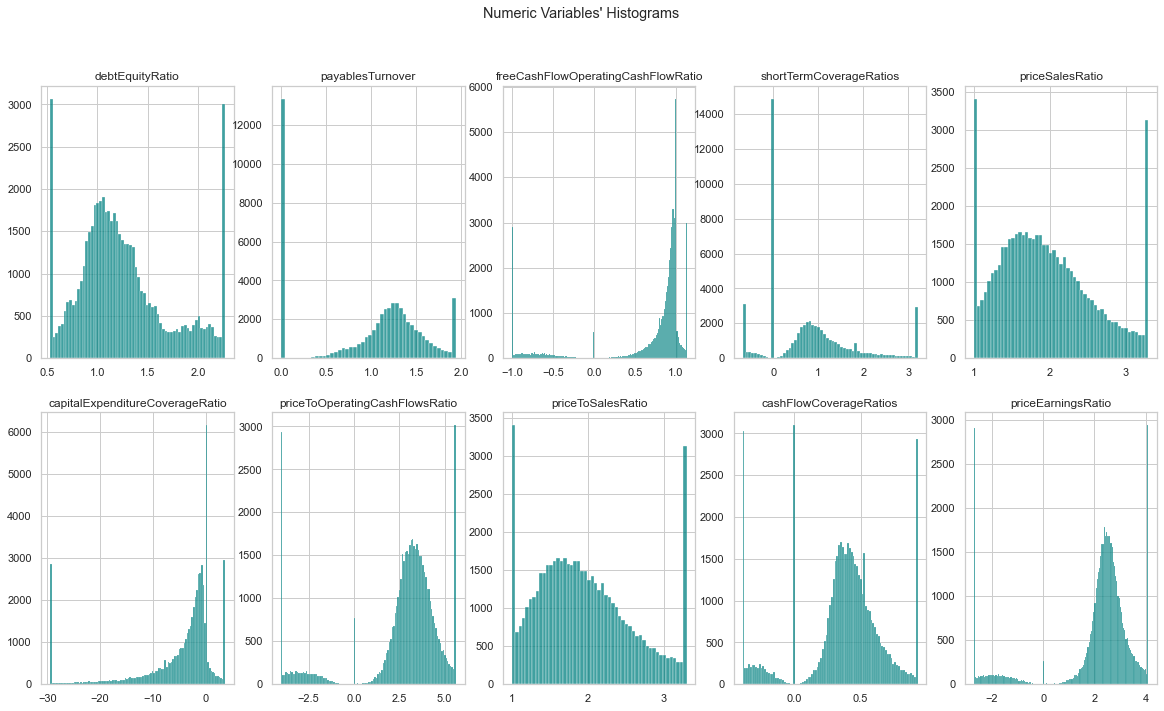

Plotting Histograms
Nr of metrics features: 10


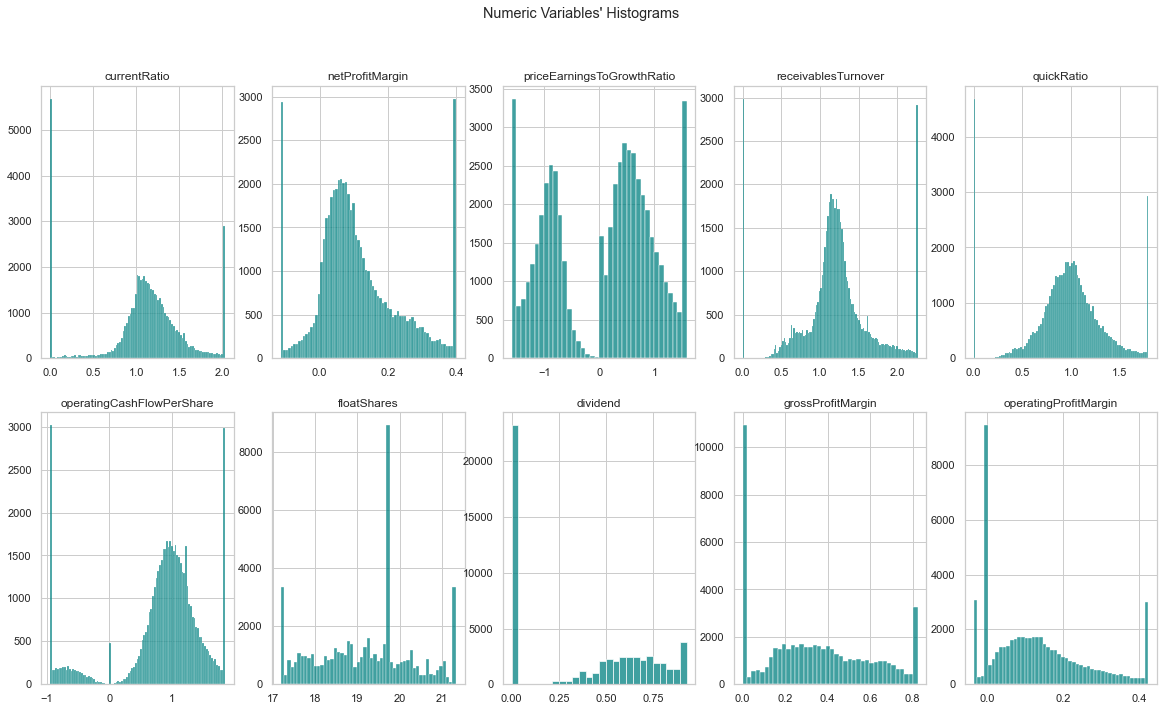

Plotting Histograms
Nr of metrics features: 10


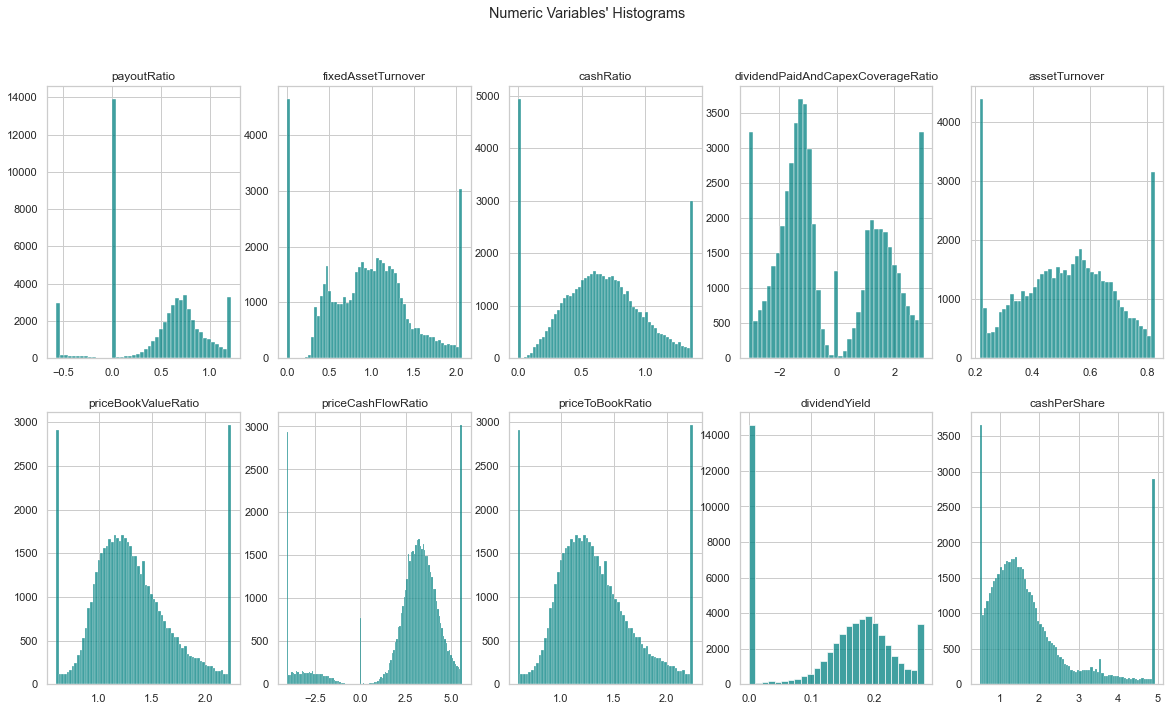

Plotting Histograms
Nr of metrics features: 10


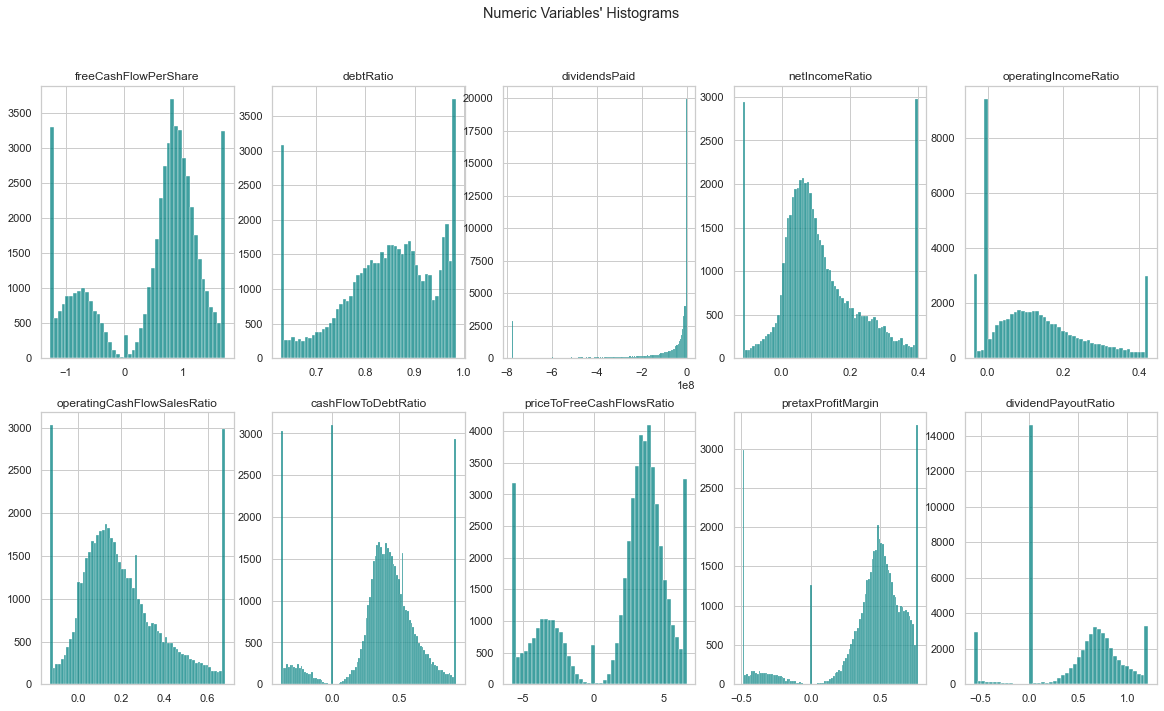

Plotting Histograms
Nr of metrics features: 8


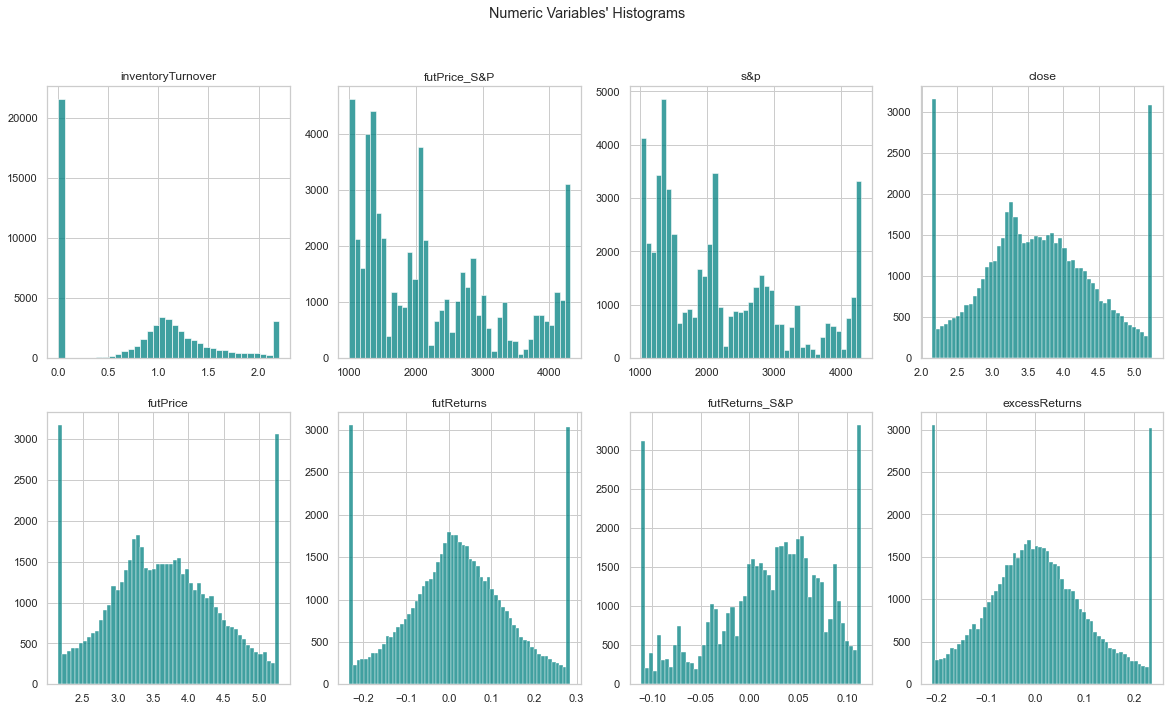

In [36]:
viz.Histogram(df_explor_orig,)

#### Target Distribution

TypeError: numpy boolean subtract, the `-` operator, is not supported, use the bitwise_xor, the `^` operator, or the logical_xor function instead.

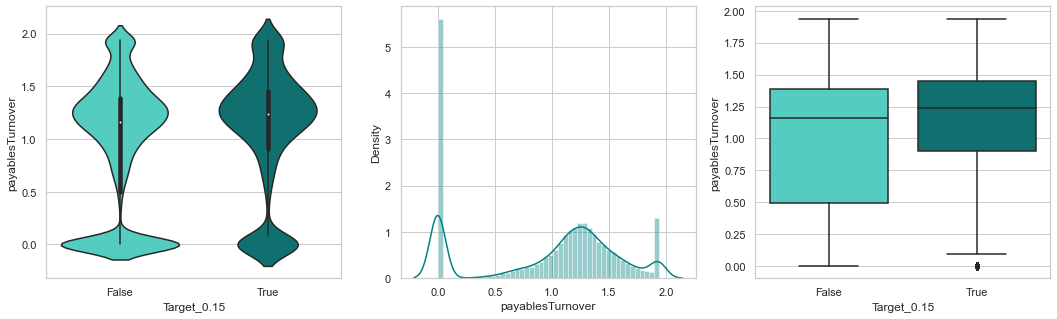

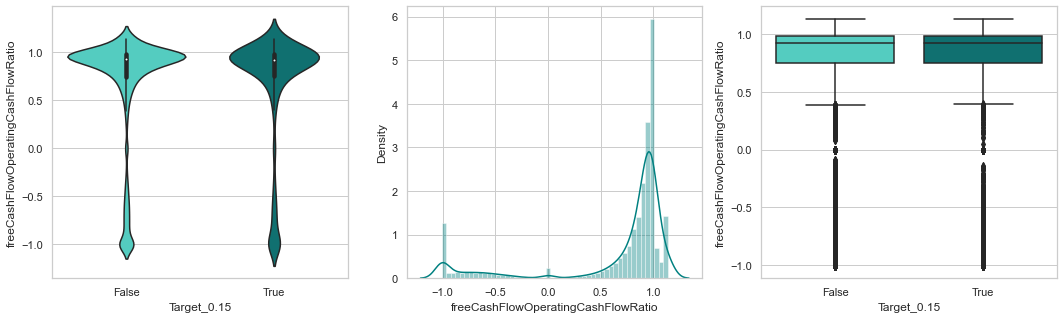

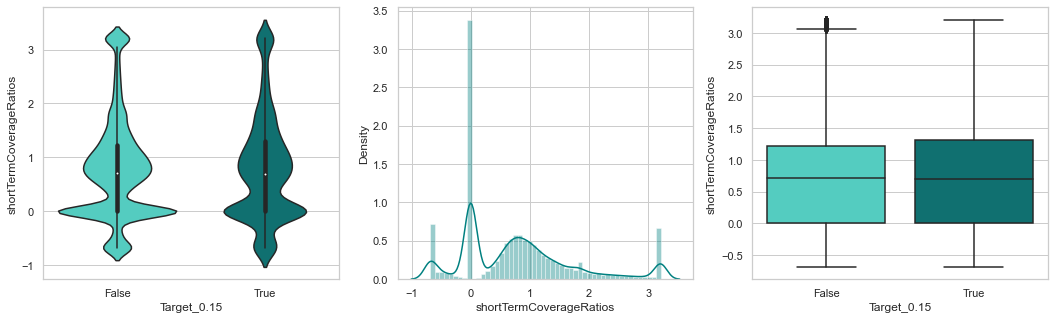

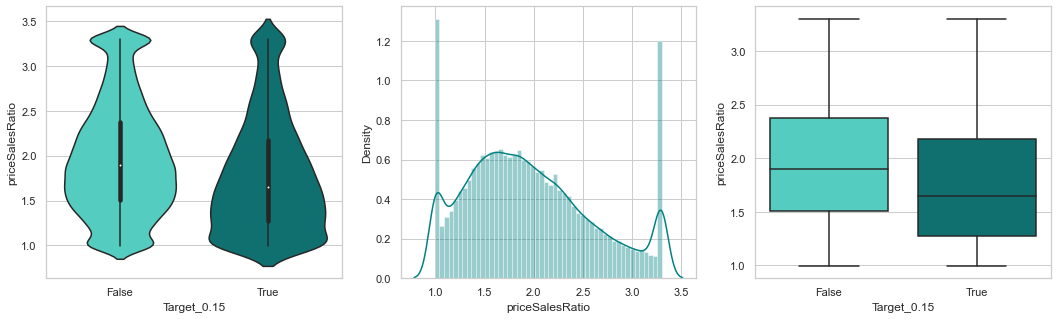

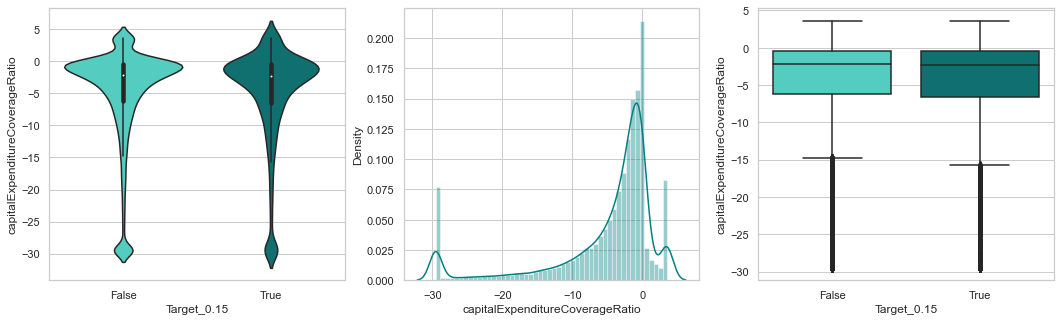

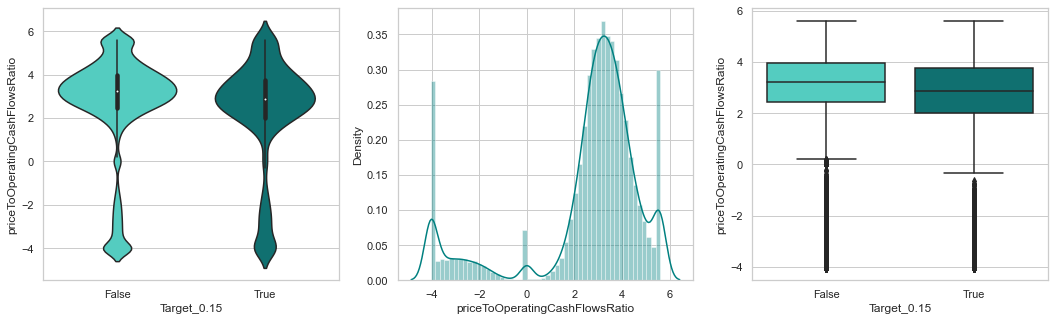

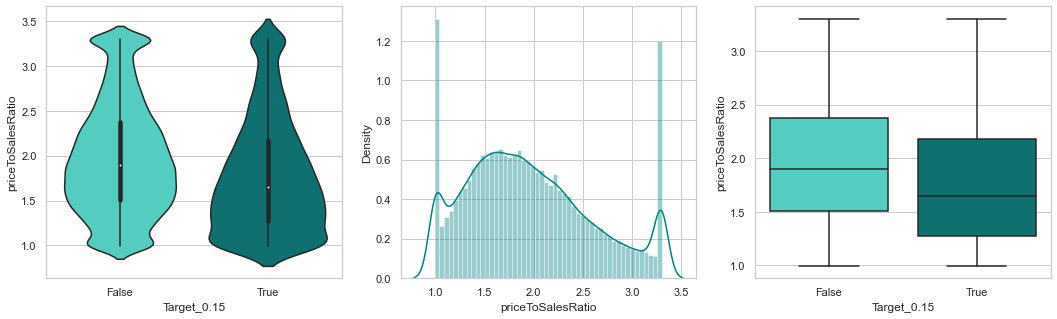

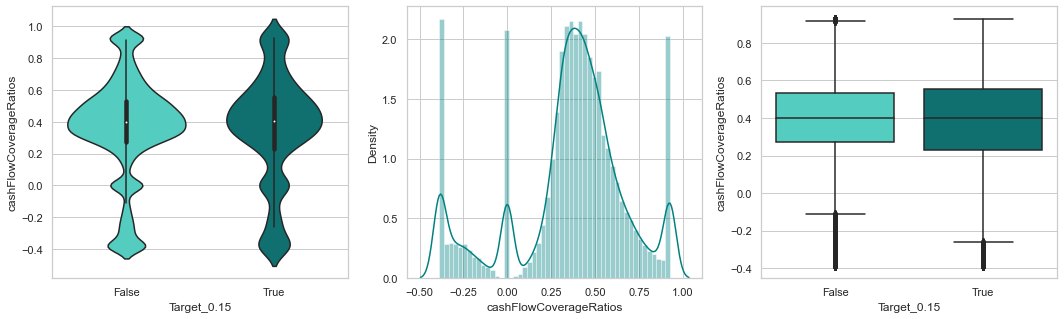

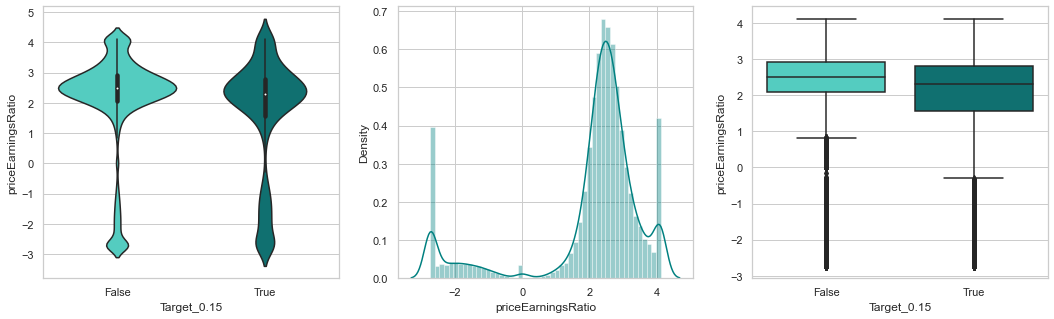

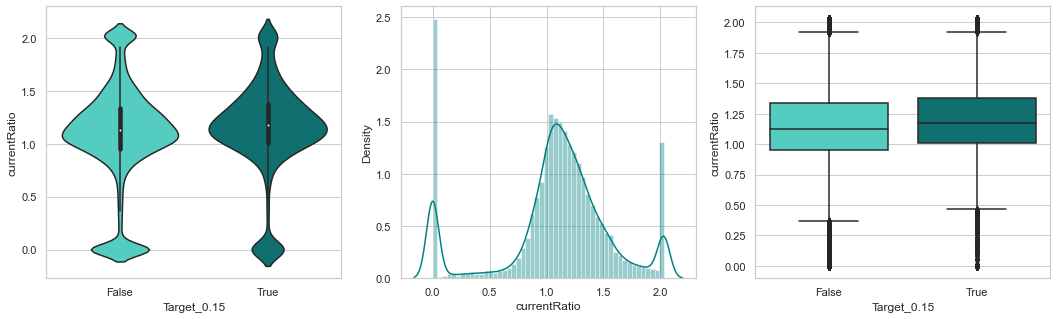

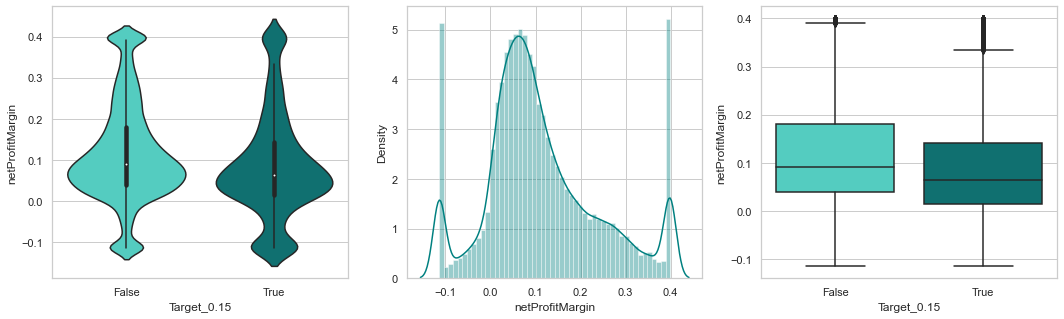

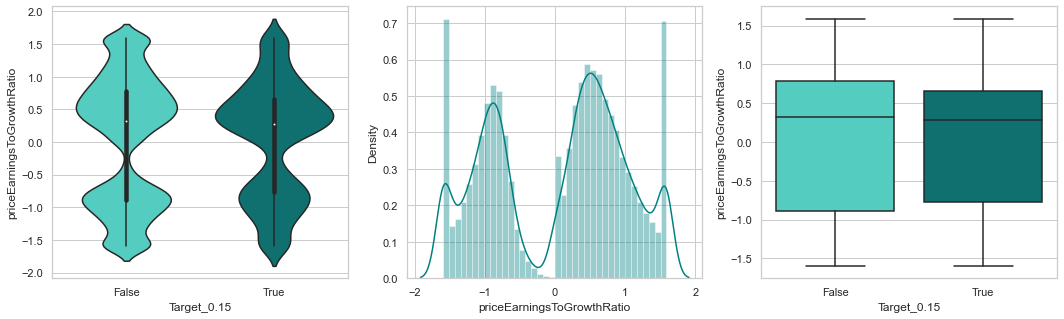

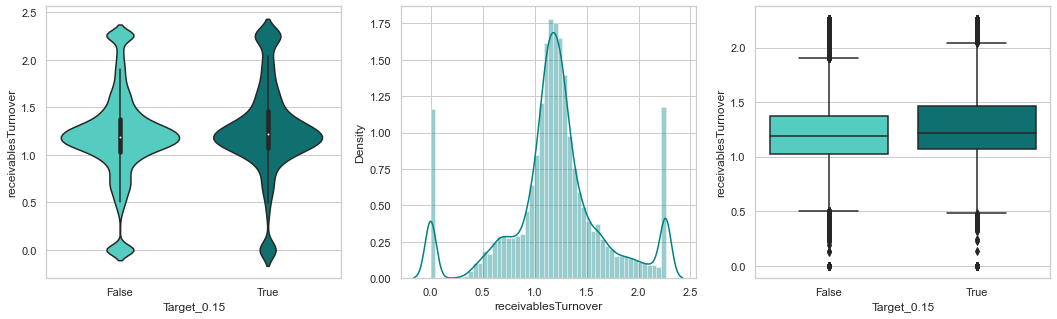

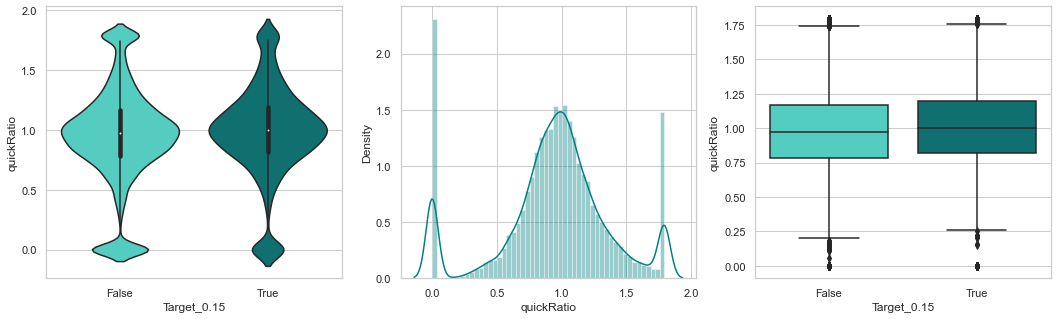

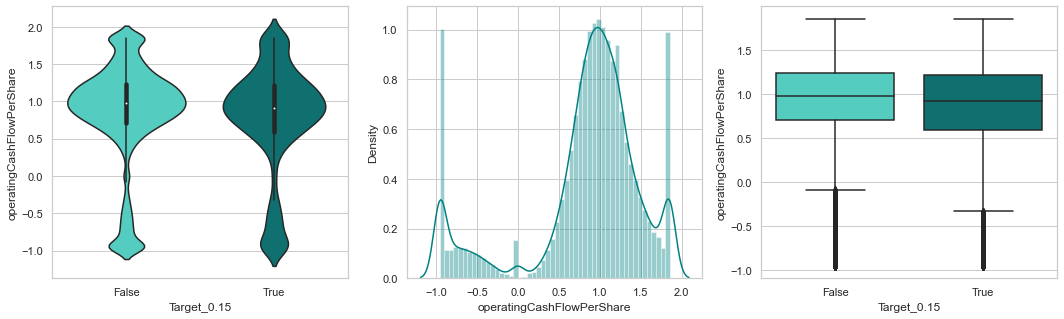

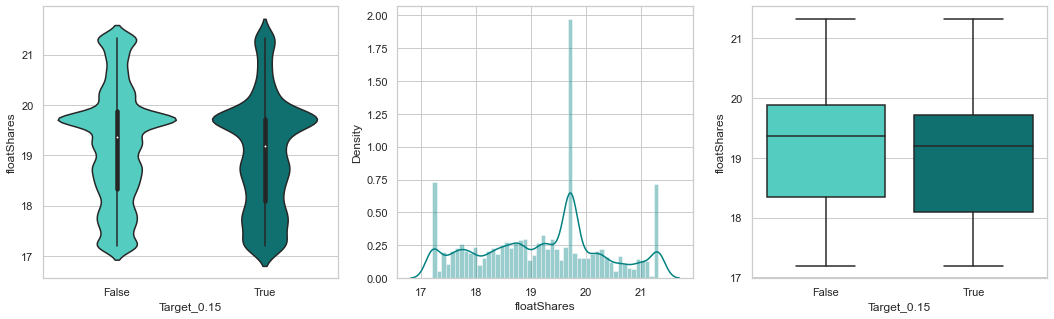

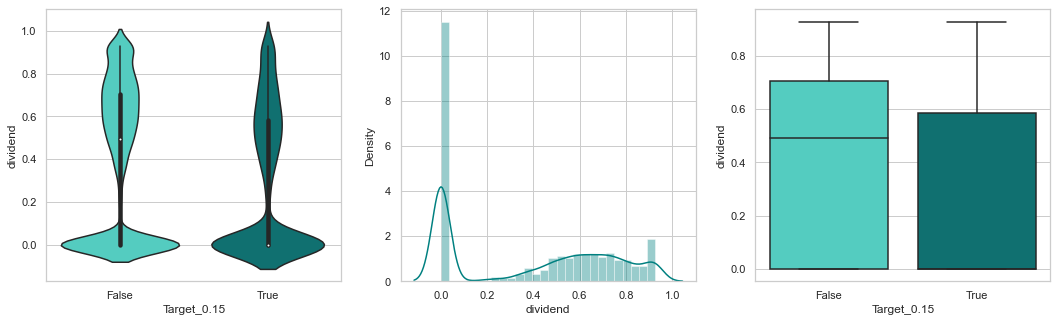

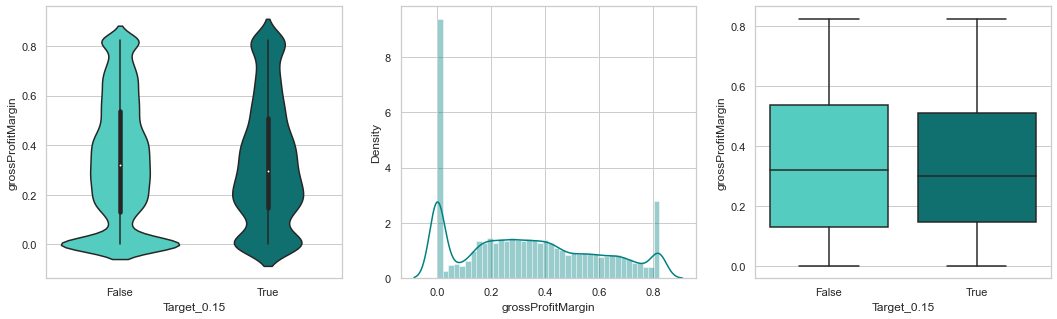

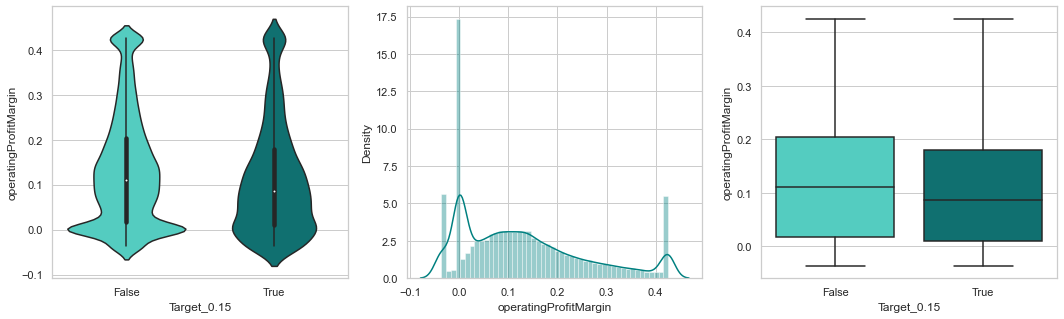

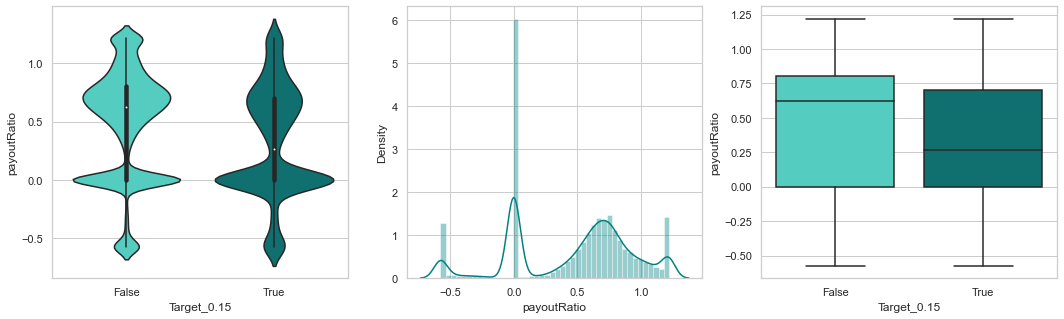

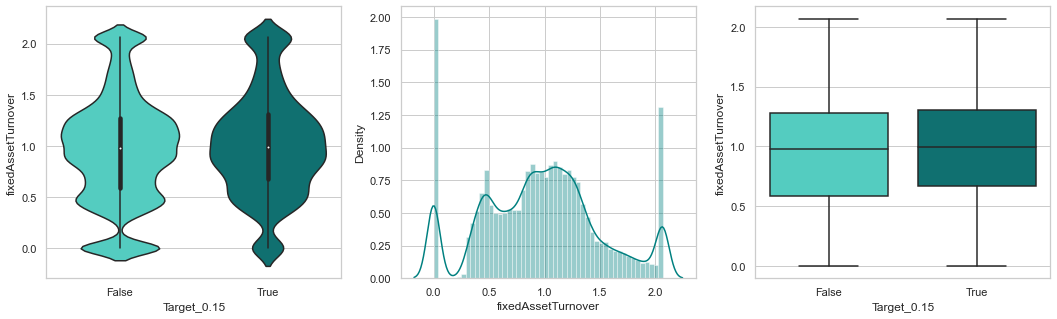

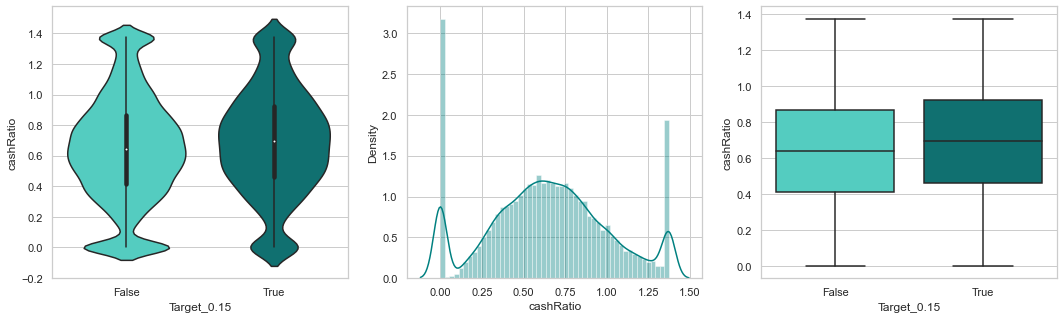

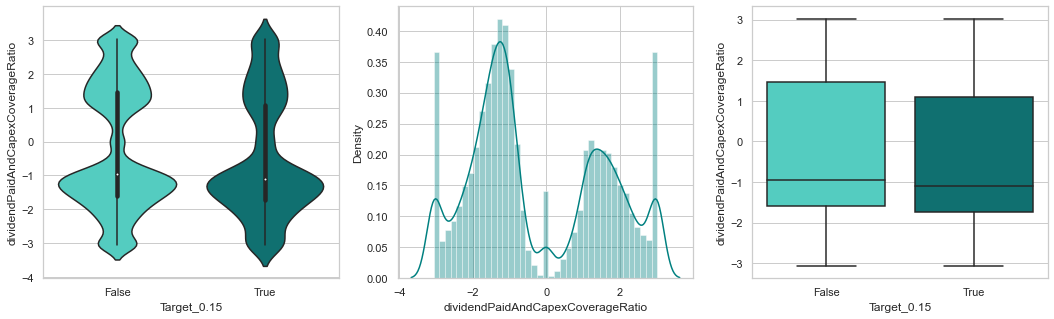

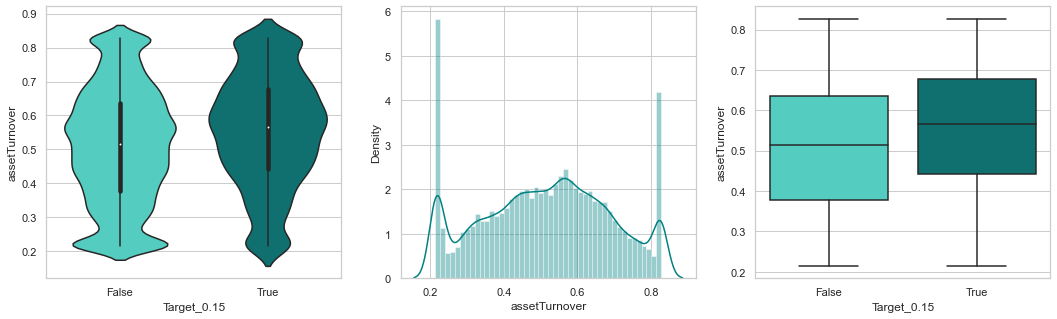

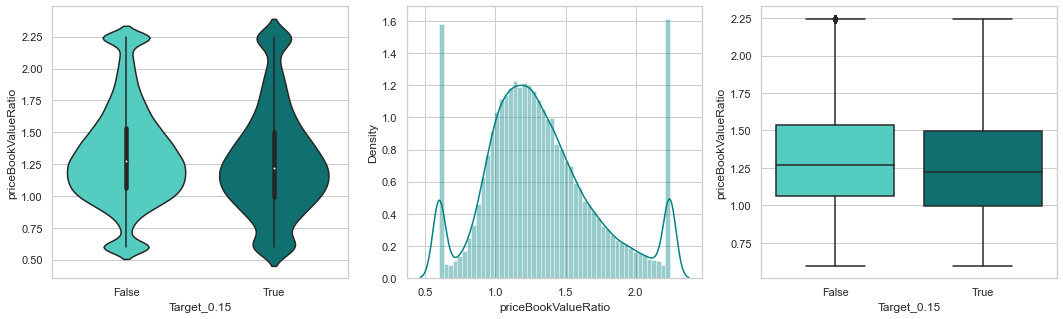

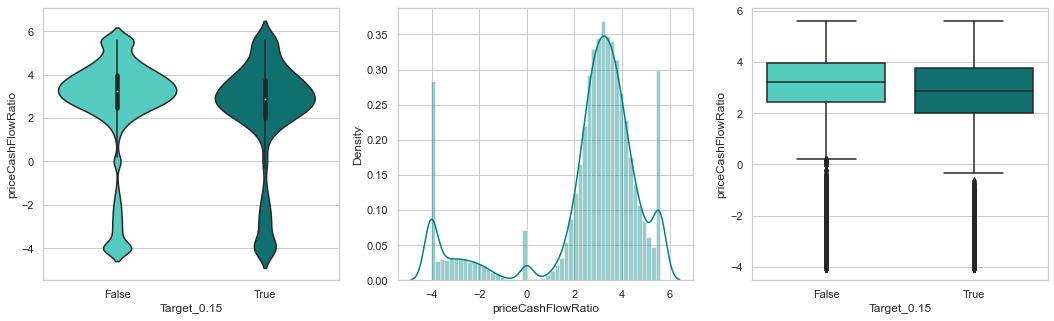

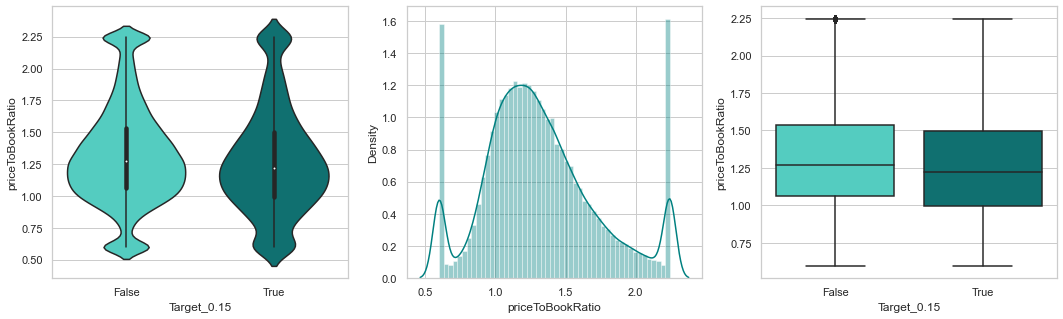

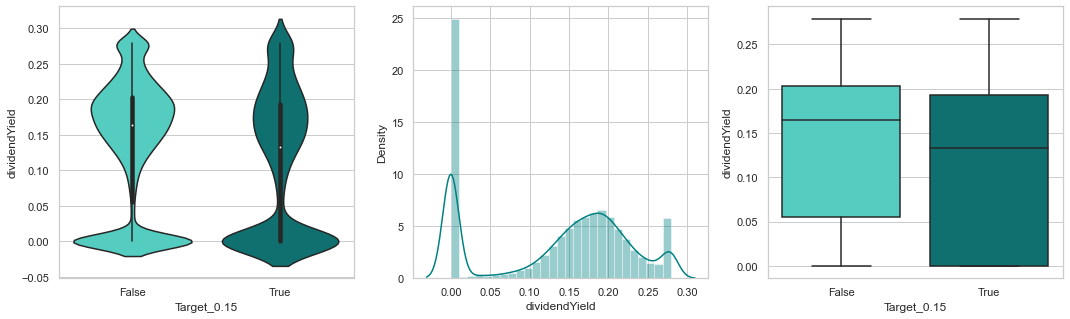

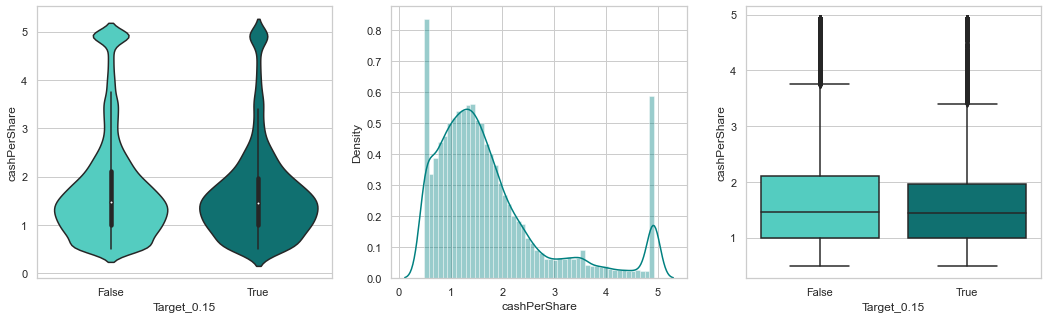

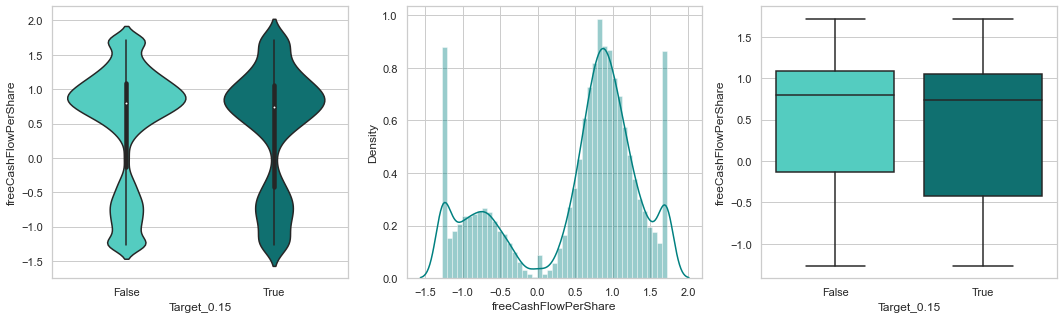

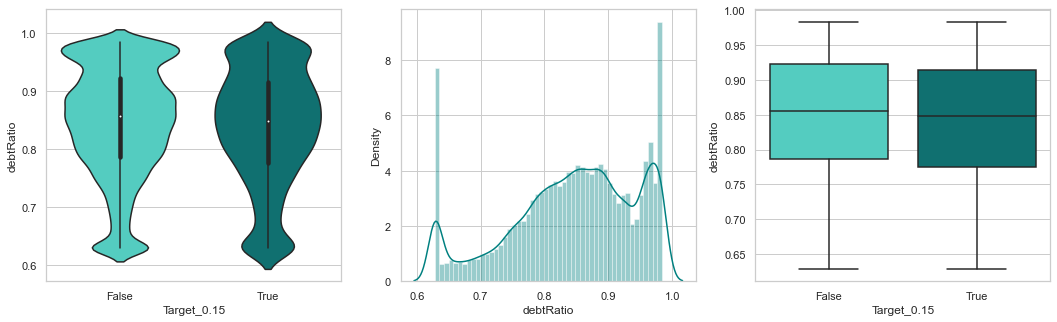

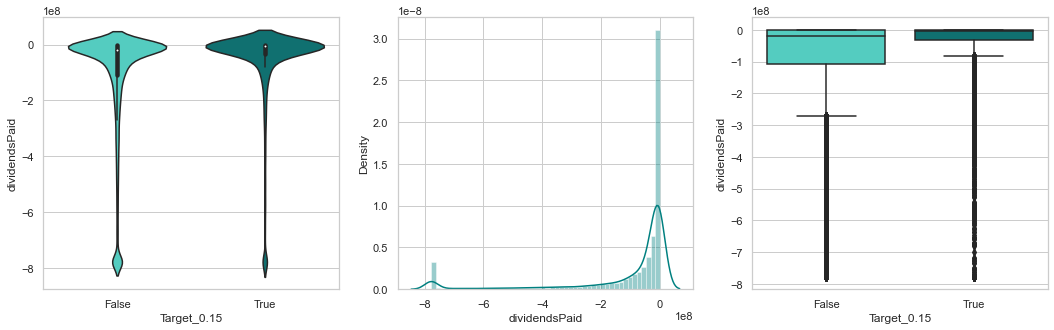

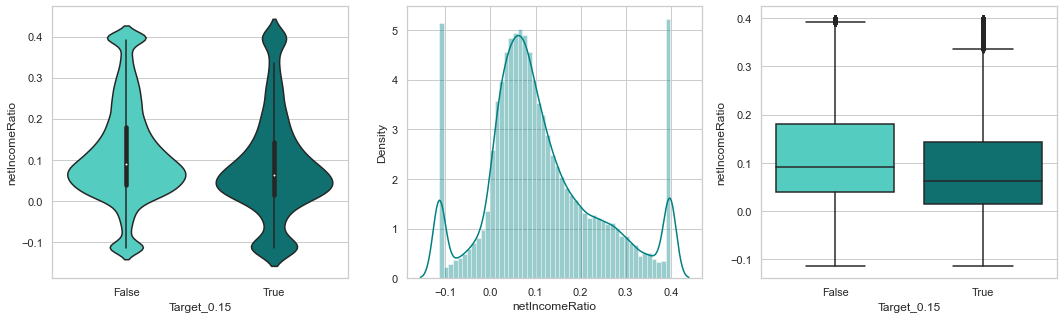

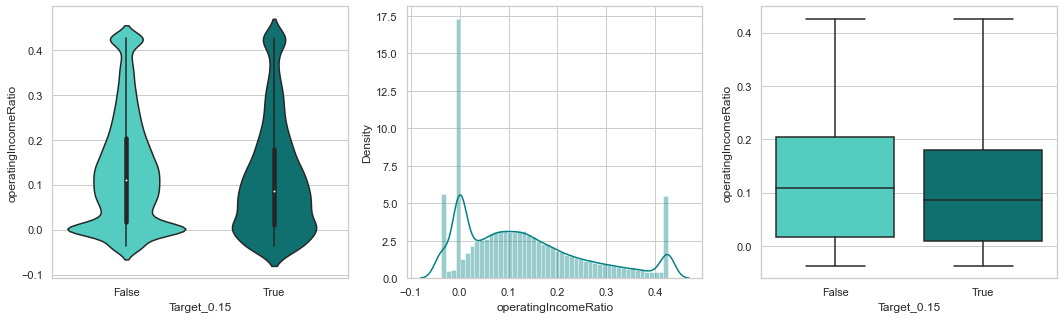

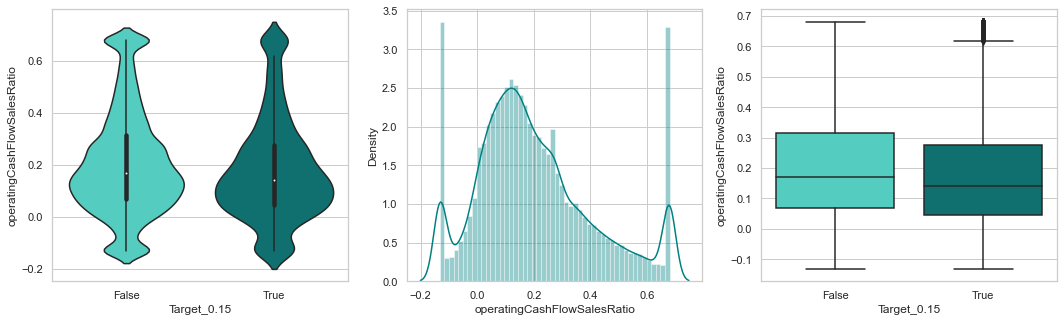

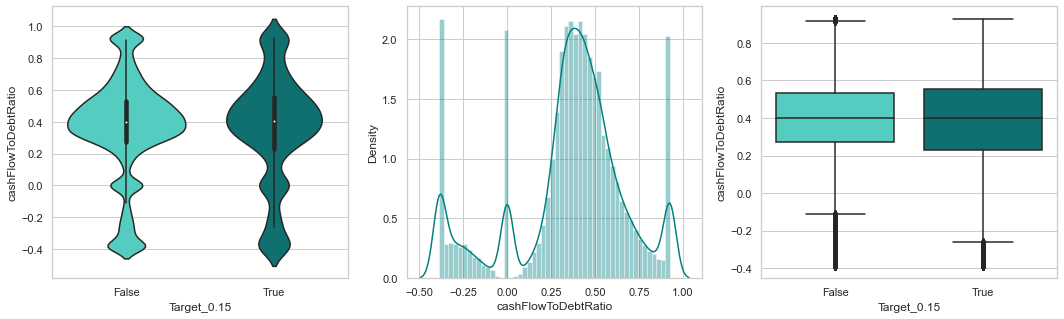

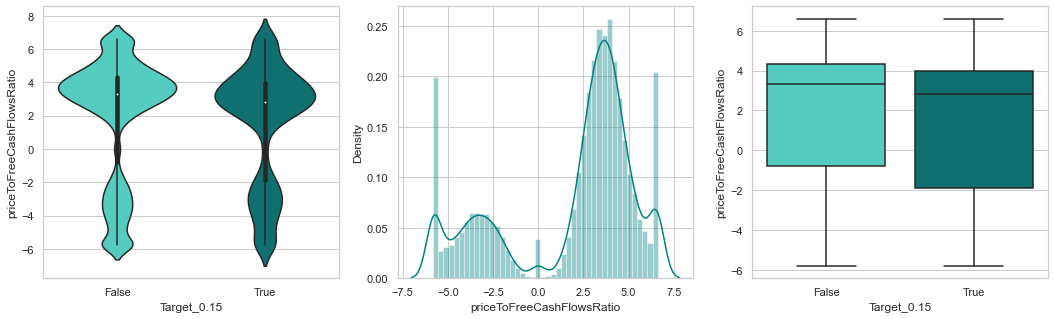

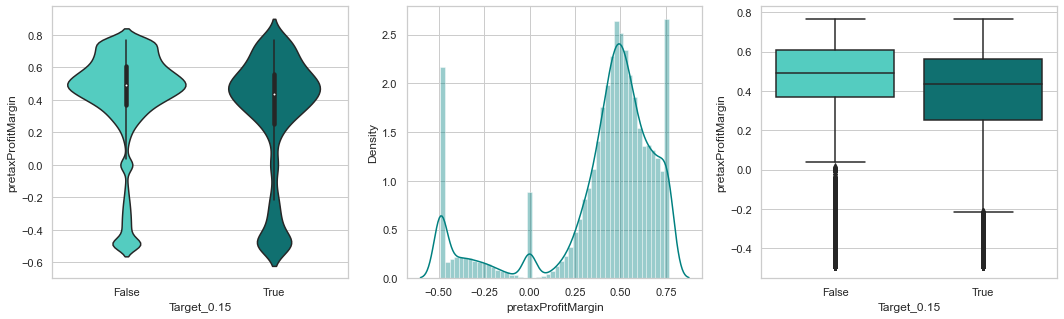

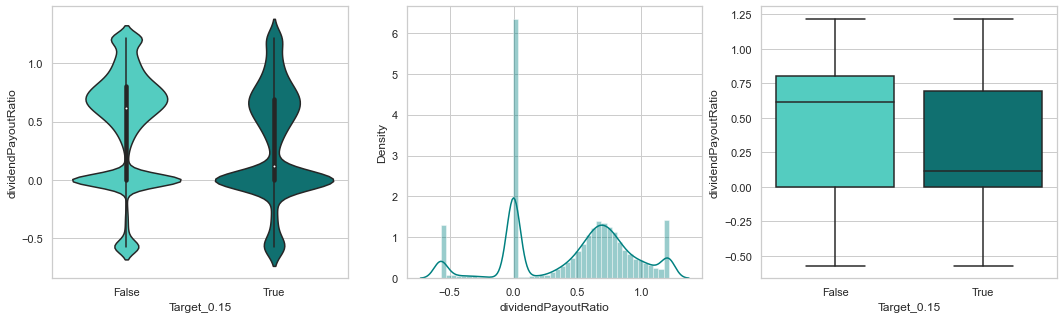

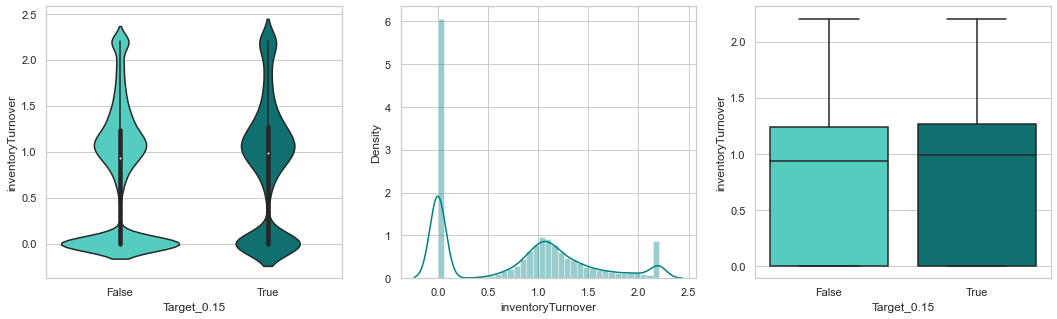

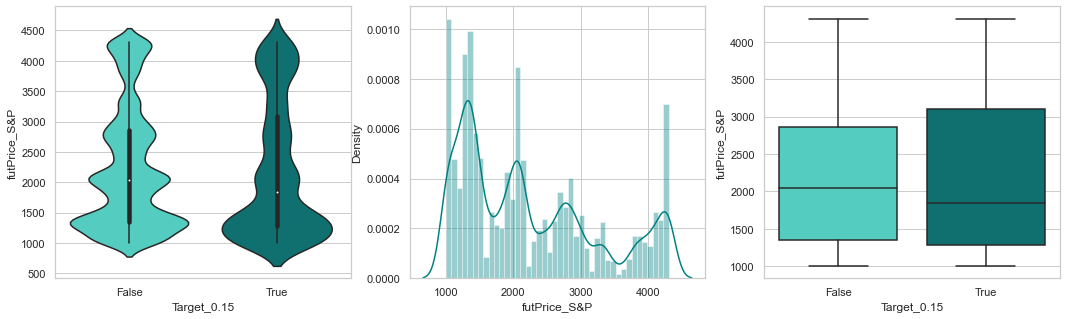

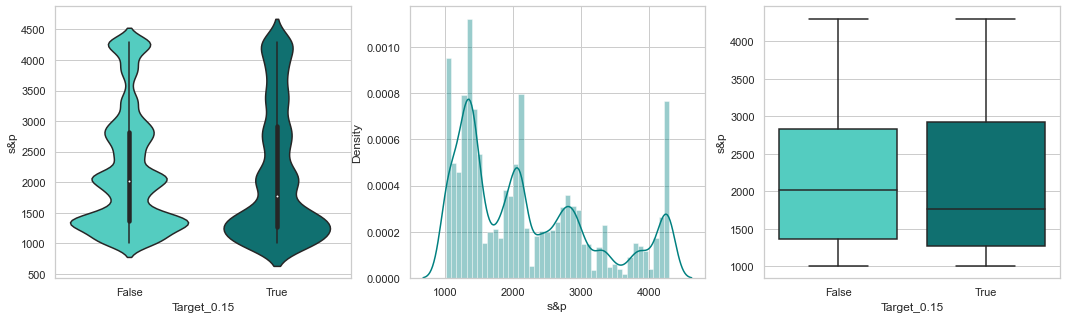

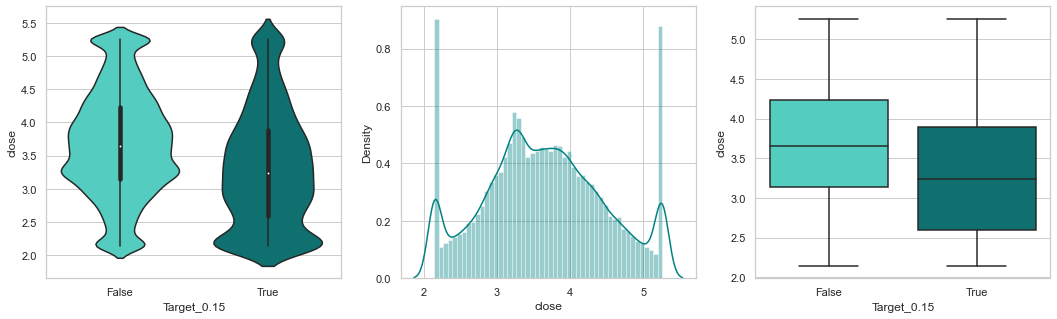

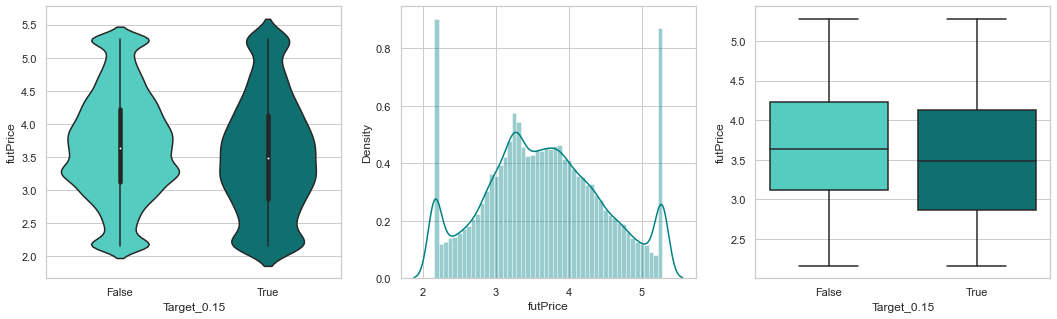

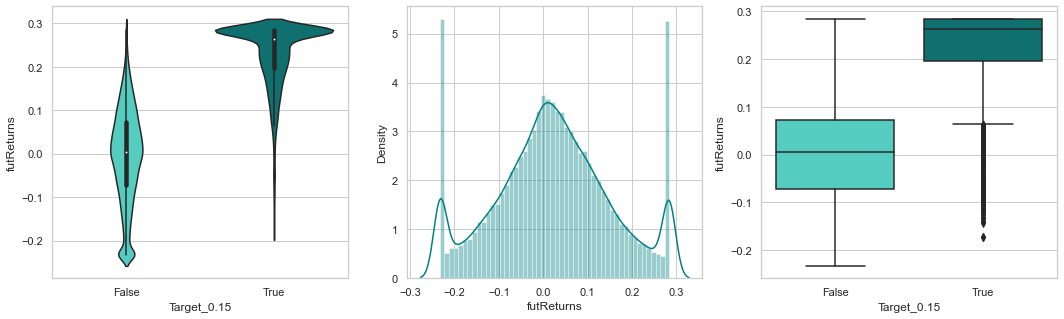

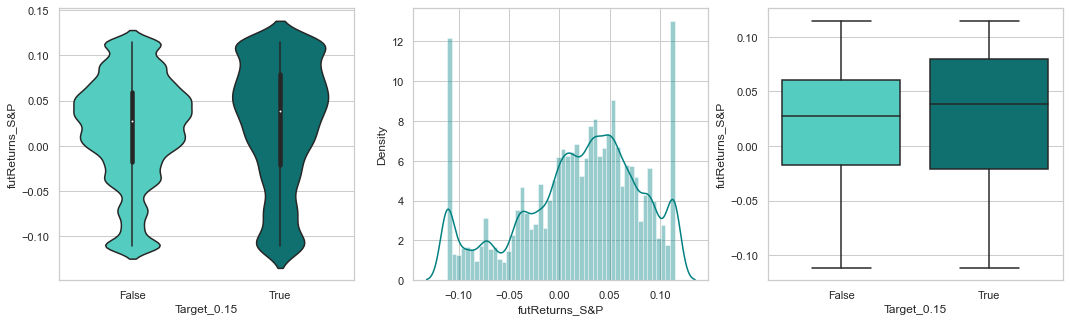

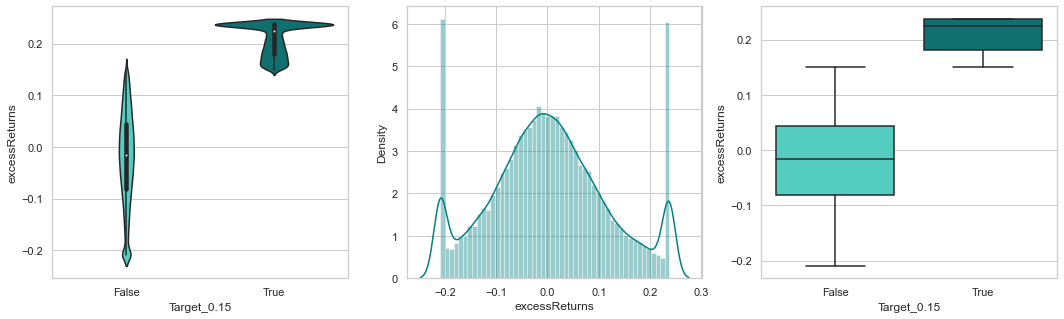

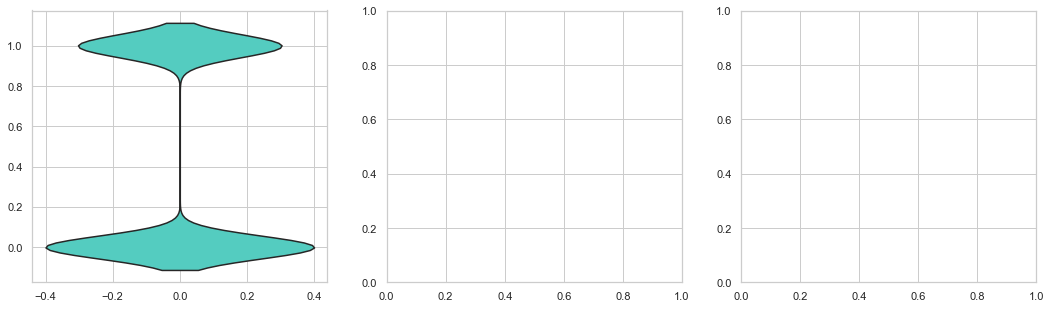

In [56]:
viz.univariate_target_analysis(df_explor_orig,'Target_0.15')

In [ ]:
viz.Target_Boxplot(df_explor_orig,'Target_0.15')

In [ ]:
viz.Target_Histogram(df_explor_orig,'Target_0.15')